# **Q1**

In [1]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Data Engineering"
master = "local"
# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

file_path_train = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTrain+.txt"
file_path_test = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTest+.txt"

train_df = spark.read.csv(file_path_train, header=False, inferSchema=True)
test_df = spark.read.csv(file_path_test, header=False, inferSchema=True)

C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer

from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import Imputer, StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy

from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import roc_curve
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']

binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment','urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        output_df = dataset.withColumn('outcome',label_to_binary(col('class'))).drop("class")
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))
        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
    
#def get_preprocess_pipeline():
def get_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                                "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol='features')
    # Stage for creating the outcome column representing whether there is attack
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
                                        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    
    ##************* added lines for logistic regression pipeline
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

    # Create ParamGrid for Cross Validation
    lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.5, 2.0])
                .addGrid(lr.maxIter, [1, 5, 10])
                .build())
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='outcome', metricName='areaUnderROC')
    
    lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=5)

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
                            stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper, lr_cv])
    return pipeline

In [4]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("HW5 Spark Machine Learning") \
    .getOrCreate()

file_path_train = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTrain+.txt"
file_path_test = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTest+.txt"

nslkdd_raw = spark.read.csv(file_path_train,header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv(file_path_test,header=False).toDF(*col_names)

pipeline = get_pipeline()

pipeline_model = pipeline.fit(nslkdd_raw)

nslkdd_df = pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = pipeline_model.transform(nslkdd_test_raw)

nslkdd_df.cache()
nslkdd_df_test.cache()

nslkdd_df_test.printSchema()
nslkdd_df_test.show(5)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------------------+-------+--------------------+--------------------+----------+
|            features|outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(113,[13,14,16,17...|    1.0|[-4.3653326088597...|[0.01255089958022...|       1.0|
|(113,[13,14,16,17...|    1.0|[-3.9491045312634...|[0.01890756579045...|       1.0|
|(113,[0,1,13,14,1...|    0.0|[1.79696740987316...|[0.85777937880514...|       0.0|
|(113,[1,13,14,17,...|    1.0|[-2.3171179288341...|[0.08971514939151...|       1.0|
|(113,[0,2,13,14,1...|    1.0|[0.21059847464032...|[0.55245588610071...|       0.0|
+--------------------+-------+--------------------+--------------------+----------+
only showing top 5 rows



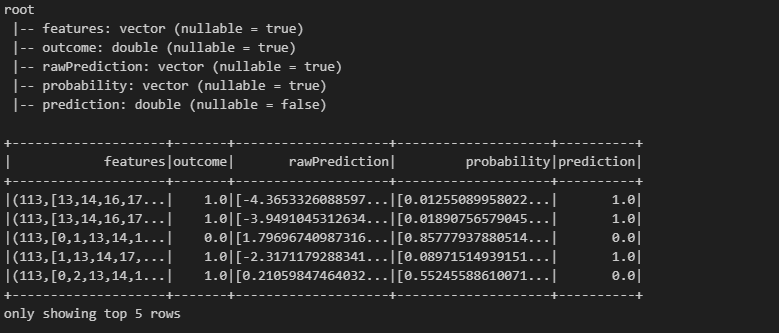


# **Q2**

### **Q2-1**

In [5]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']

binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment','urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_multiclass = udf(lambda name: 
                                  #normal
                                  0.0 if name == 'normal' else 
                                  #DoS
                                  1.0 if name in ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', ' processtable',
                                                   'smurf', 'teardrop', 'udpstorm', 'worm'] else
                                  #R2L
                                  2.0 if name in ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 'phf',
                                                   'sendmail', 'Snmpgetattack', 'spy', 'snmpguess', 'warezclient', 'warezmaster', 'xlock', 'xsnoop'] else
                                  #U2R
                                  3.0 if name in ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm'] else
                                  #Probing
                                  4.0 if name in ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'] else
                                  -1.0, DoubleType())
        output_df = dataset.withColumn('outcome',label_to_multiclass(col('class'))).drop("class")
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))
        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df
    

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                                "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol='features')
    # Stage for creating the outcome column representing whether there is attack
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
                                        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
                            stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline

### **Q2-2**

In [6]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [7]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("HW5-Q2-Spark-Machine_Learning") \
    .getOrCreate()

file_path_train = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTrain+.txt"
file_path_test = r"C:\Users\nickc\OneDrive\Documents\GitHub\hw5-sparkml-nick1117\NSL-KDD\KDDTest+.txt"

nslkdd_raw = spark.read.csv(file_path_train,header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv(file_path_test,header=False).toDF(*col_names)

pipeline = get_preprocess_pipeline()

pipeline_model = pipeline.fit(nslkdd_raw)

nslkdd_df = pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = pipeline_model.transform(nslkdd_test_raw)

nslkdd_df.cache()
nslkdd_df_test.cache()

nslkdd_df_test.printSchema()
nslkdd_df_test.show(5)

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(113,[13,14,16,17...|    1.0|
|(113,[13,14,16,17...|    1.0|
|(113,[0,1,13,14,1...|    0.0|
|(113,[1,13,14,17,...|    4.0|
|(113,[0,2,13,14,1...|    4.0|
+--------------------+-------+
only showing top 5 rows



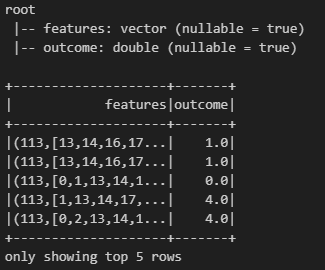

In [8]:
#Random forest
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')
rf_model = rf.fit(nslkdd_df)

rf_prediction_train = rf_model.transform(nslkdd_df)
rf_prediction_test = rf_model.transform(nslkdd_df_test)

rf_accuracy_train = (rf_prediction_train.filter(rf_prediction_train.outcome == rf_prediction_train.prediction).count()/ float(rf_prediction_train.count()))
rf_accuracy_test = (rf_prediction_test.filter(rf_prediction_test.outcome == rf_prediction_test.prediction).count() / float(rf_prediction_test.count()))

print(f"Random Forest - Train accuracy = {np.round(rf_accuracy_train*100,2)}%, test accuracy = {np.round(rf_accuracy_test*100,2)}%")

#logistic regression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')
lr_model = lr.fit(nslkdd_df)

lr_prediction_train = lr_model.transform(nslkdd_df)
lr_prediction_test = lr_model.transform(nslkdd_df_test)

lr_accuracy_train = (lr_prediction_train.filter(lr_prediction_train.outcome == lr_prediction_train.prediction).count()/ float(lr_prediction_train.count()))
lr_accuracy_test = (lr_prediction_test.filter(lr_prediction_test.outcome == lr_prediction_test.prediction).count() / float(lr_prediction_test.count()))

# lr_accuracy_train = evaluator.evaluate(lr_prediction_train)
# lr_accuracy_test = evaluator.evaluate(lr_prediction_test)

print(f"Logistic Regression - Train accuracy = {np.round(lr_accuracy_train*100, 2)}%, Test accuracy = {np.round(lr_accuracy_test*100, 2)}%")


Random Forest - Train accuracy = 96.61%, test accuracy = 71.69%
Logistic Regression - Train accuracy = 98.76%, Test accuracy = 75.93%


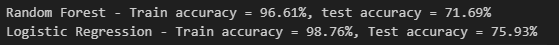

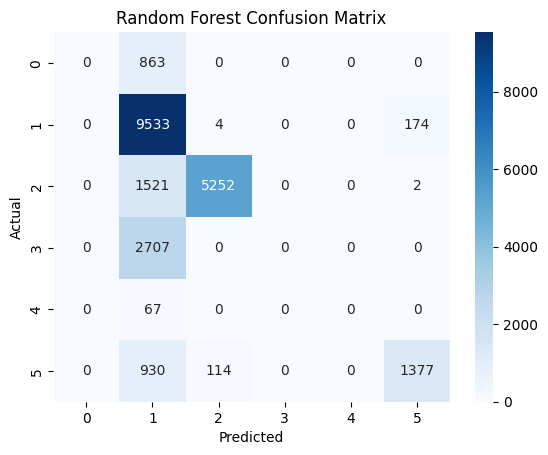

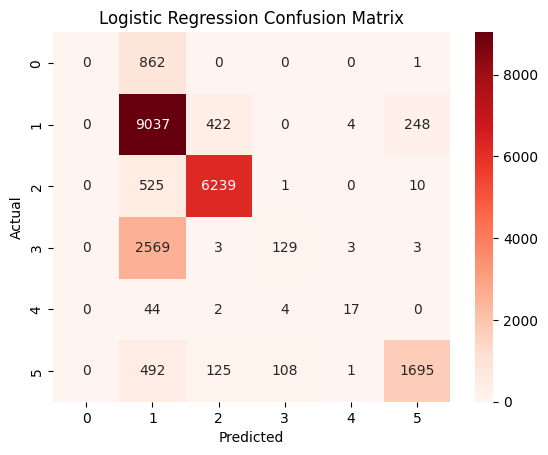

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#labels = ['Normal', 'DoS', 'R2L', 'U2R', 'Probing']

rf_confusion = rf_prediction_test.select('outcome', 'prediction').toPandas()
cm_rf = confusion_matrix(rf_confusion['outcome'], rf_confusion['prediction'])
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

lr_confusion = lr_prediction_test.select('outcome', 'prediction').toPandas()
cm_lr = confusion_matrix(lr_confusion['outcome'], lr_confusion['prediction'])
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Reds")
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

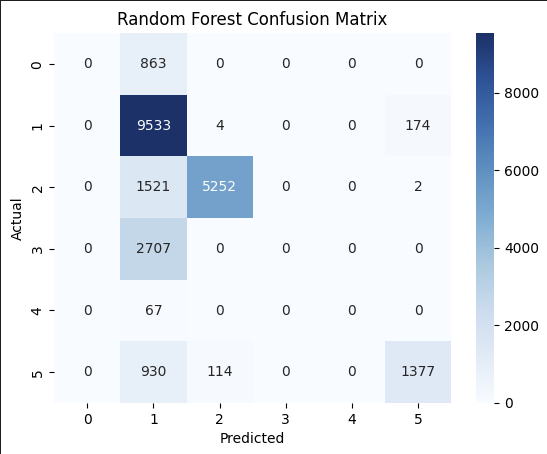
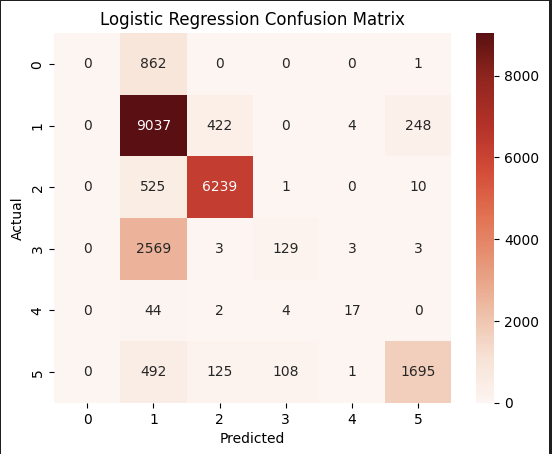

### **Q2-3**

In [10]:
evaluator = MulticlassClassificationEvaluator(labelCol="outcome", predictionCol="prediction", metricName="accuracy")

#random forest

rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [5, 10, 15])# maximum depth for each tree
                .addGrid(rf.numTrees,[10, 20, 40])# number of trues
                .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, evaluator=evaluator, numFolds=5)

rf_cv_model = rf_cv.fit(nslkdd_df)
rf_cv_prediction_test = rf_cv_model.transform(nslkdd_df_test)
rf_cv_acc = evaluator.evaluate(rf_cv_prediction_test)

print(f"Random forest accuracy after tuning: {np.round(rf_cv_acc*100, 2)}%")

#Logisitc Regression

lr_paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.maxIter, [1, 5, 10])
            .build())

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=5)

lr_cv_model = lr_cv.fit(nslkdd_df)
lr_cv_prediction_test = lr_cv_model.transform(nslkdd_df_test)
lr_cv_acc = evaluator.evaluate(lr_cv_prediction_test)

print(f"Logisitc Regression accuracy after tuning: {np.round(lr_cv_acc*100, 2)}%")


Random forest accuracy after tuning: 73.54%
Logisitc Regression accuracy after tuning: 72.08%


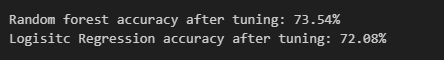

### **Q2-4**

**Random Forest:**

I chose random forests as one of my models as it can model complex relationships in the data and is less likely to overfit compared to a single decision tree. Random Forest is also works well on both small and large datasets.

maxDepth: Controls how deep individual trees grow. A larger depth allows the model to capture more complex patterns but can increase overfitting. A smaller depth ensures that the trees are simpler and and a smaller chance of overfitting. However because of this they might miss out on key relationships in the data. 

numTrees: Controls the number of trees in the forest. More trees generally increase accuracy but also increase computation time and memory usage. There is a tradeoff between model performance and computational efficiency.

**Logisitic Regression:**

I chose logisitic regression as my other model since Logiistic regression is a simple and widely used classification algorithm. While it does work on multi-class datasets, being a linear model, it might not work well on highly complex datasets. But being as commoon as it is and simple to impliment and interpret, I thought it would be a good baseline to work off of. Also it is computationally efficicent.

regParam: Can test a range of regularization strengths. This range allows me to see how the model behaves with little regularization (0.01), moderate regularization (0.5), and strong regularization (2.0).
maxIter: Can assess how quickly the model converges with a small number of iterations versus when given more time to refine its decision boundary.


## **Q2-5**

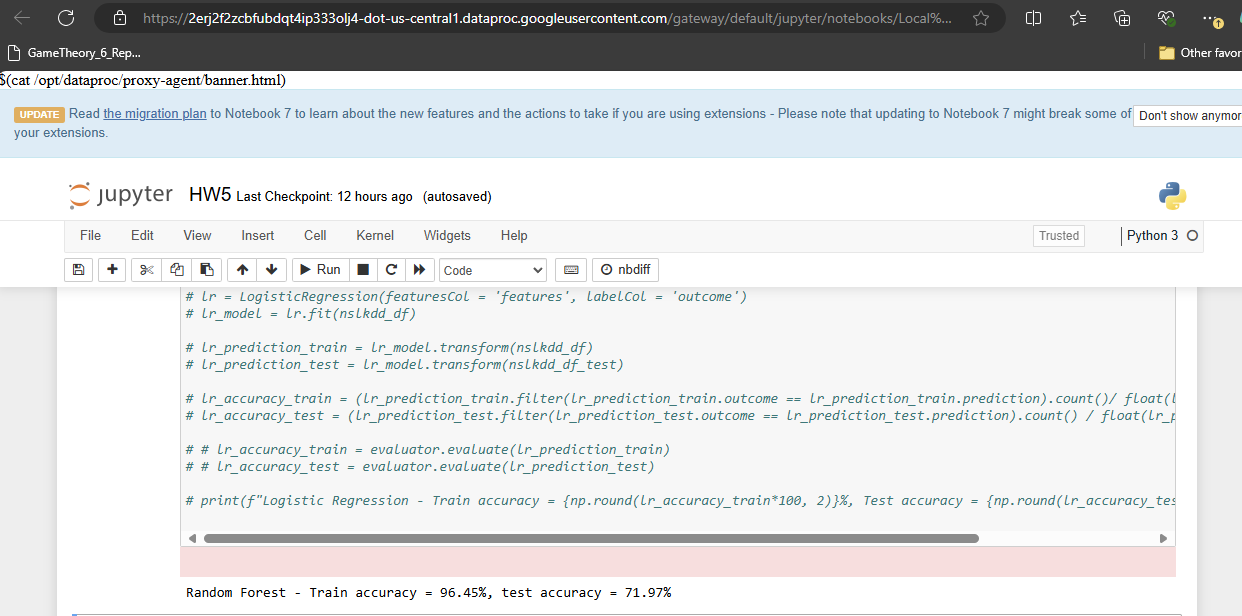
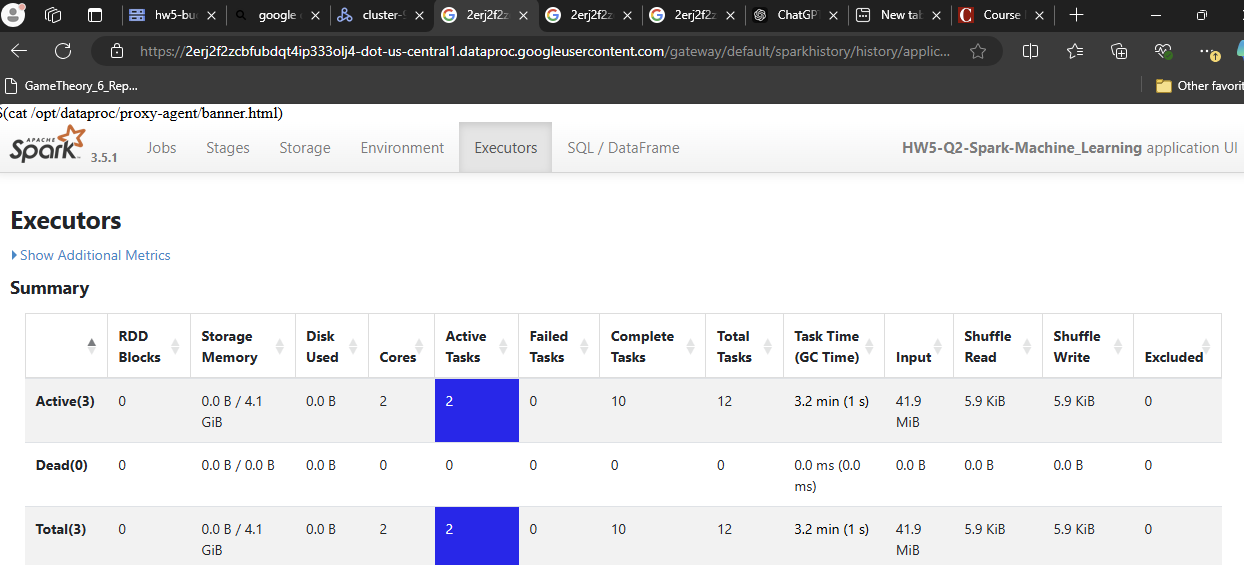
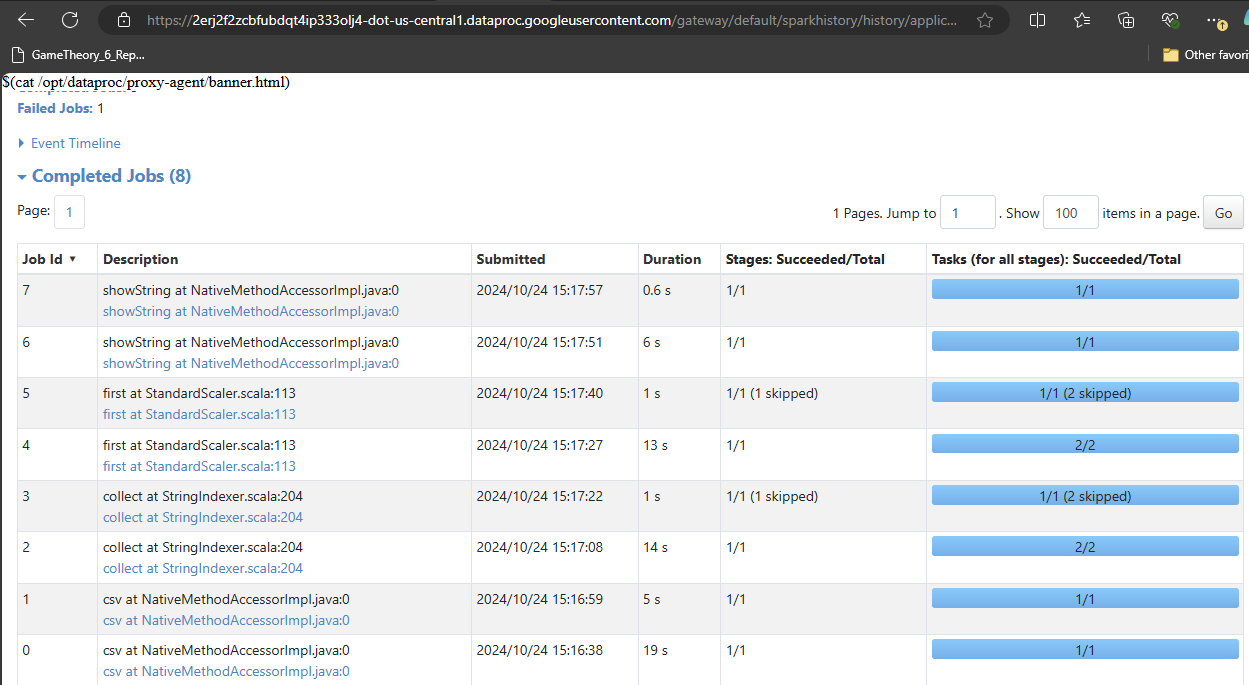

## **Q2-6**

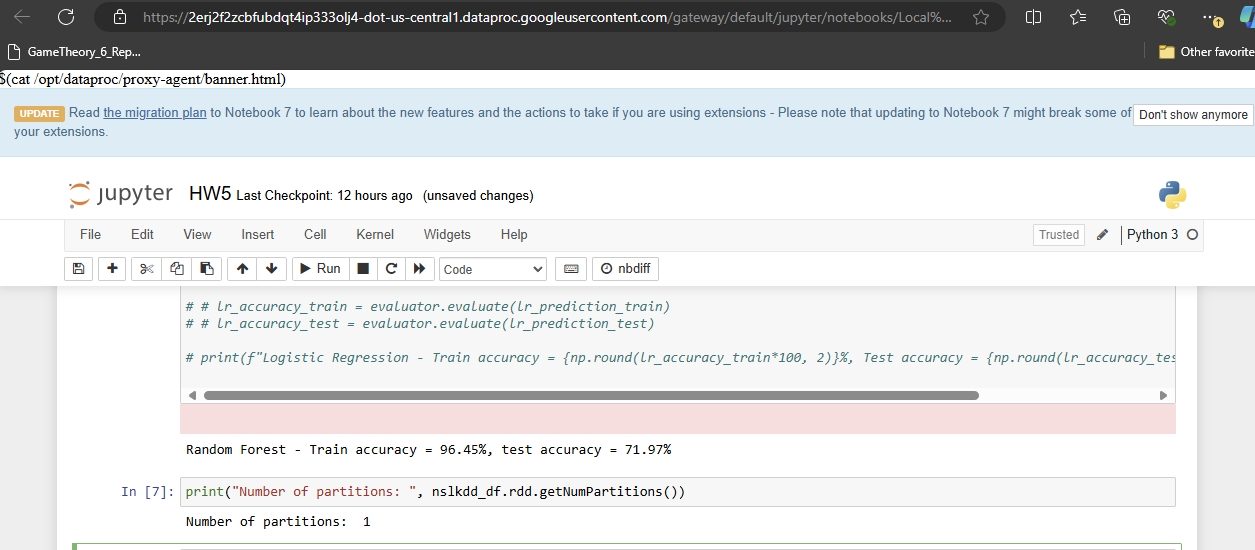